In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'diabetes'
table_name = 'diabetes'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

diabetes_df = pd.read_sql_query('select * from diabetes',con=engine)
diabetes_df_winsor = diabetes_df

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

In [3]:
diabetes_df.info()
diabetes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        763 non-null    int64  
 1   glucose            763 non-null    int64  
 2   blood_pressure     763 non-null    int64  
 3   skin_thickness     763 non-null    int64  
 4   insulin            763 non-null    int64  
 5   bmi                763 non-null    float64
 6   diabetes_pedigree  763 non-null    float64
 7   age                763 non-null    int64  
 8   outcome            763 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 53.8 KB


,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
0,5,44,62,0,0,25.0,0.587,36,0
1,2,56,56,28,45,24.2,0.332,22,0
2,9,57,80,37,0,32.8,0.096,41,0
3,0,57,60,0,0,21.7,0.735,67,0
4,3,61,82,28,0,34.4,0.243,46,0


The data types look good. Check for null/missing values.

In [4]:
diabetes_df.isnull().sum().sum()

0

No null values, so we can move on to checking for outliers.

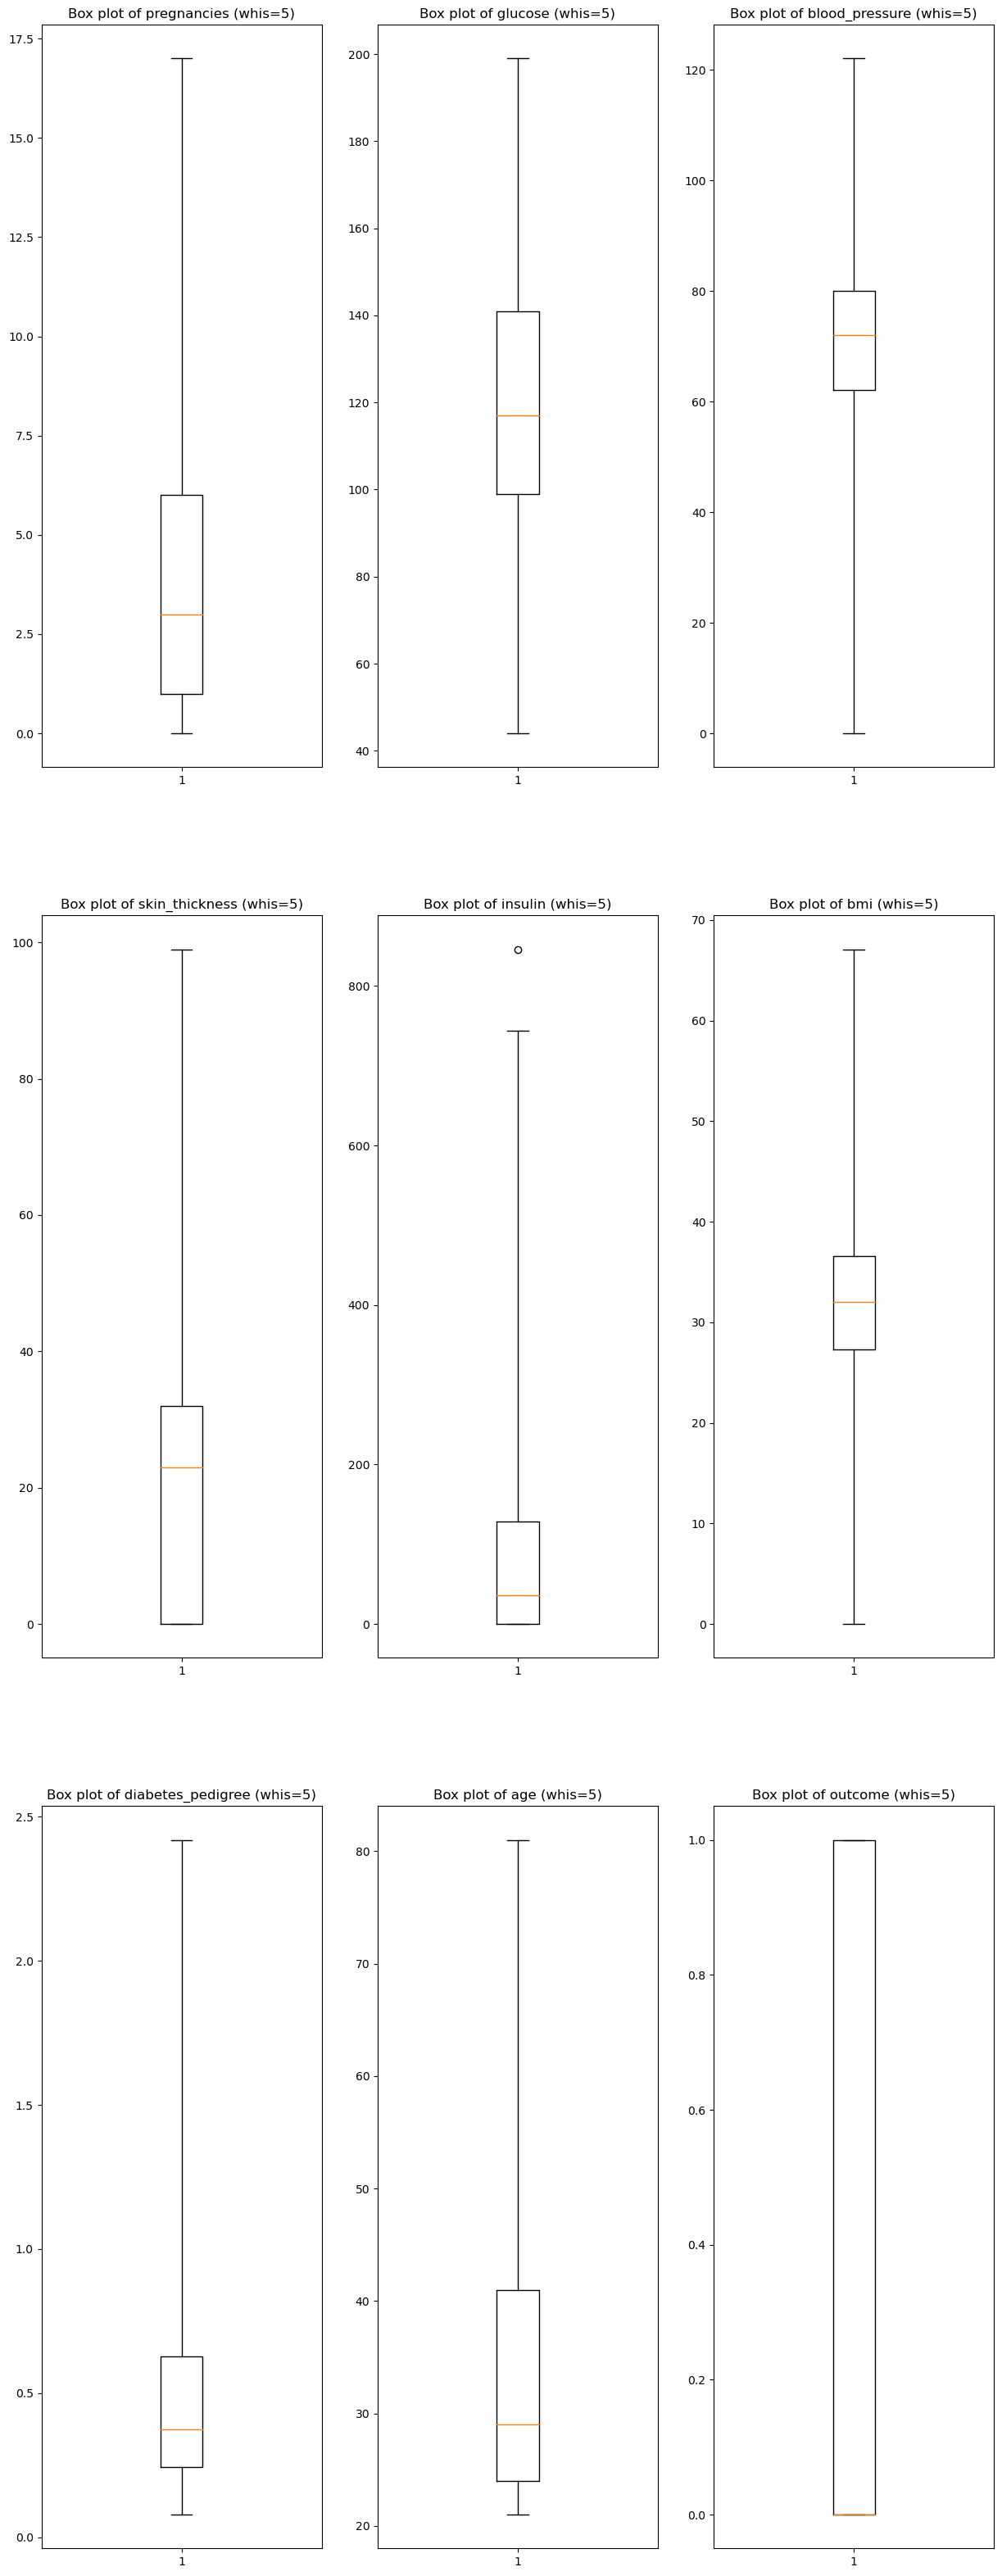

In [46]:
plt.figure(figsize = (15,40))

plt.subplot(3,3,1)
plt.boxplot(diabetes_df["pregnancies"], whis=5)
plt.title("Box plot of pregnancies (whis=5)")

plt.subplot(3,3,2)
plt.boxplot(diabetes_df["glucose"], whis=5)
plt.title("Box plot of glucose (whis=5)")

plt.subplot(3,3,3)
plt.boxplot(diabetes_df["blood_pressure"], whis=5)
plt.title("Box plot of blood_pressure (whis=5)")

plt.subplot(3,3,4)
plt.boxplot(diabetes_df["skin_thickness"], whis=5)
plt.title("Box plot of skin_thickness (whis=5)")

plt.subplot(3,3,5)
plt.boxplot(diabetes_df["insulin"], whis=5)
plt.title("Box plot of insulin (whis=5)")

plt.subplot(3,3,6)
plt.boxplot(diabetes_df["bmi"], whis=5)
plt.title("Box plot of bmi (whis=5)")

plt.subplot(3,3,7)
plt.boxplot(diabetes_df["diabetes_pedigree"], whis=5)
plt.title("Box plot of diabetes_pedigree (whis=5)")

plt.subplot(3,3,8)
plt.boxplot(diabetes_df["age"], whis=5)
plt.title("Box plot of age (whis=5)")

plt.subplot(3,3,9)
plt.boxplot(diabetes_df["outcome"], whis=5)
plt.title("Box plot of outcome (whis=5)")

plt.show()

Insulin has a few outliers, so we will handle those using windsor.

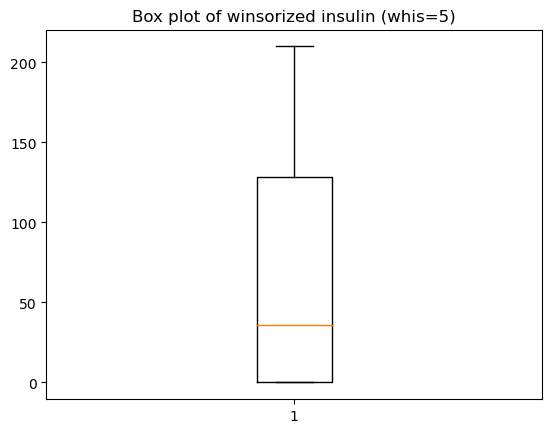

In [21]:
from scipy.stats.mstats import winsorize

# Apply one-way winsorization to the highest end
# of the value distribution. Because you have a lot of extreme
# values, set the values of the outliers to the 
# value of the ninetieth percentile. 
win_insulin = winsorize(diabetes_df["insulin"], (0, 0.10))

plt.boxplot(win_insulin, whis=5)
plt.title("Box plot of winsorized insulin (whis=5)")
plt.show()

Outliers have been removed. Now we can move onto exploration.

In [25]:
diabetes_df["win_insulin"] = win_insulin
diabetes_df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome,win_insulin
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,3.851900,121.686763,69.115334,20.477064,66.699869,31.986763,0.472477,33.271298,0.348624,66.699869
std,3.374729,30.535641,19.399240,15.973171,77.586665,7.893221,0.331963,11.772161,0.476847,77.586665
min,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374000,29.000000,0.000000,36.000000
75%,6.000000,141.000000,80.000000,32.000000,128.500000,36.550000,0.626500,41.000000,1.000000,128.500000
max,17.000000,199.000000,122.000000,99.000000,210.000000,67.100000,2.420000,81.000000,1.000000,210.000000


In [31]:
diabetes_df.corr()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome,win_insulin
pregnancies,1.000000,0.128135,0.140481,-0.082435,-0.093891,0.014874,-0.036063,0.542558,0.218877,-0.093891
glucose,0.128135,1.000000,0.158429,0.075178,0.269914,0.235666,0.137246,0.267136,0.494650,0.269914
blood_pressure,0.140481,0.158429,1.000000,0.207590,0.104782,0.280781,0.040426,0.239038,0.063602,0.104782
skin_thickness,-0.082435,0.075178,0.207590,1.000000,0.522209,0.391542,0.183840,-0.114804,0.072382,0.522209
insulin,-0.093891,0.269914,0.104782,0.522209,1.000000,0.210554,0.192574,-0.088950,0.112971,1.000000
bmi,0.014874,0.235666,0.280781,0.391542,0.210554,1.000000,0.139227,0.033258,0.289297,0.210554
diabetes_pedigree,-0.036063,0.137246,0.040426,0.183840,0.192574,0.139227,1.000000,0.030896,0.172292,0.192574
age,0.542558,0.267136,0.239038,-0.114804,-0.088950,0.033258,0.030896,1.000000,0.235145,-0.088950
outcome,0.218877,0.494650,0.063602,0.072382,0.112971,0.289297,0.172292,0.235145,1.000000,0.112971
win_insulin,-0.093891,0.269914,0.104782,0.522209,1.000000,0.210554,0.192574,-0.088950,0.112971,1.000000


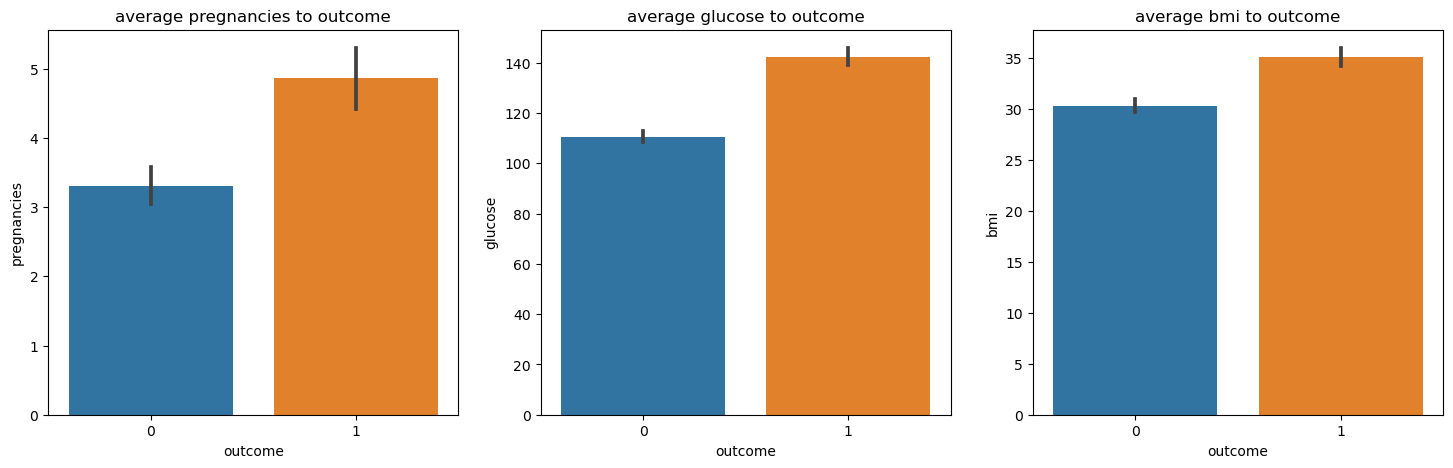

In [35]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.barplot(x=diabetes_df["outcome"], y=diabetes_df["pregnancies"])
plt.title("average pregnancies to outcome")

plt.subplot(1,3,2)
sns.barplot(x=diabetes_df["outcome"], y=diabetes_df["glucose"])
plt.title("average glucose to outcome")

plt.subplot(1,3,3)
sns.barplot(x=diabetes_df["outcome"], y=diabetes_df["bmi"])
plt.title("average bmi to outcome")
plt.show()

Based on the correlation matrix and barplots, glucose has the highest correlation at .49, followed by BMI at .29 and finally pregnancies at .22. Using this information, we can narrow down the variables we will be inspecting down to those three.

Start off by checking for normality.

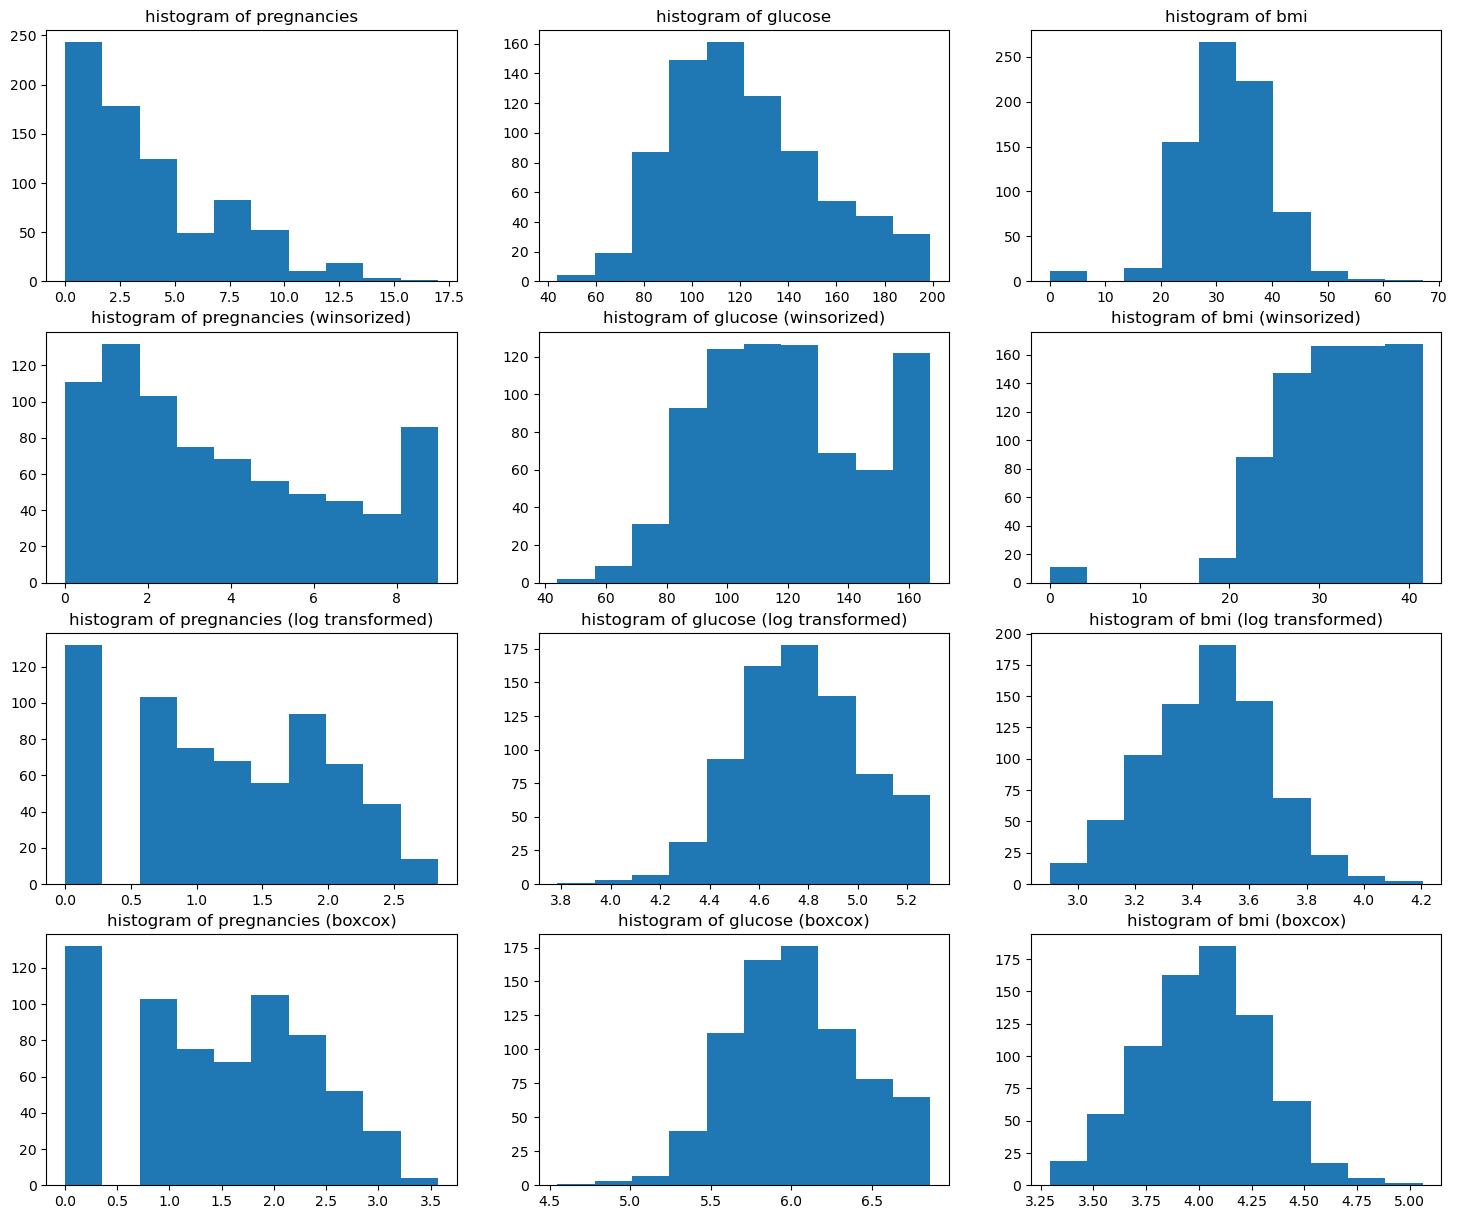

In [47]:
plt.figure(figsize=(18,15))

pregnancies_boxcox,_ = boxcox(diabetes_df[diabetes_df["pregnancies"] > 0]["pregnancies"])
glucose_boxcox,_ = boxcox(diabetes_df["glucose"])
bmi_boxcox,_ = boxcox(diabetes_df[diabetes_df["bmi"] > 0]["bmi"])

# Histograms of the original data
plt.subplot(4, 3, 1)
plt.hist(diabetes_df["pregnancies"])
plt.title("histogram of pregnancies")

plt.subplot(4, 3, 2)
plt.hist(diabetes_df["glucose"])
plt.title("histogram of glucose")

plt.subplot(4, 3, 3)
plt.hist(diabetes_df["bmi"])
plt.title("histogram of bmi")

# Histograms of the winsorized data
plt.subplot(4, 3, 4)
plt.hist(winsorize(diabetes_df["pregnancies"], (0, 0.10)))
plt.title("histogram of pregnancies (winsorized)")

plt.subplot(4, 3, 5)
plt.hist(winsorize(diabetes_df["glucose"], (0, 0.10)))
plt.title("histogram of glucose (winsorized)")

plt.subplot(4, 3, 6)
plt.hist(winsorize(diabetes_df["bmi"], (0, 0.10)))
plt.title("histogram of bmi (winsorized)")

# Histograms of the log-transformed data
plt.subplot(4, 3, 7)
plt.hist(np.log(diabetes_df[diabetes_df["pregnancies"] > 0]["pregnancies"]))
plt.title("histogram of pregnancies (log transformed)")

plt.subplot(4, 3, 8)
plt.hist(np.log(diabetes_df["glucose"]))
plt.title("histogram of glucose (log transformed)")

plt.subplot(4, 3, 9)
plt.hist(np.log(diabetes_df[diabetes_df["bmi"] > 0]["bmi"]))
plt.title("histogram of bmi (log transformed)")

# Histograms of the boxcox-transformed data
plt.subplot(4, 3, 10)
plt.hist(pregnancies_boxcox)
plt.title("histogram of pregnancies (boxcox)")

plt.subplot(4, 3, 11)
plt.hist(glucose_boxcox)
plt.title("histogram of glucose (boxcox)")

plt.subplot(4, 3, 12)
plt.hist(bmi_boxcox)
plt.title("histogram of bmi (boxcox)")

plt.show()

In [48]:
jb_stats = jarque_bera(diabetes_df["pregnancies"])
norm_stats = normaltest(diabetes_df["pregnancies"])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["glucose"])
norm_stats = normaltest(diabetes_df["glucose"])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["bmi"])
norm_stats = normaltest(diabetes_df["bmi"])
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 103.08869676081498 and p value is 4.1169341930302293e-23
Normality test statistics is 79.25929632063402 and p value is 6.152653877750306e-18
Jarque-Bera test statistics is 38.261199471389496 and p value is 4.916840263139804e-09
Normality test statistics is 35.369143152404106 and p value is 2.0877964251847365e-08
Jarque-Bera test statistics is 362.94610665127175 and p value is 1.5390556605374568e-79
Normality test statistics is 85.81500040639773 and p value is 2.3201145598110468e-19


In [49]:
jb_stats = jarque_bera(winsorize(diabetes_df["pregnancies"], (0, 0.10)))
norm_stats = normaltest(winsorize(diabetes_df["pregnancies"], (0, 0.10)))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(winsorize(diabetes_df["glucose"], (0, 0.10)))
norm_stats = normaltest(winsorize(diabetes_df["glucose"], (0, 0.10)))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(winsorize(diabetes_df["bmi"], (0, 0.10)))
norm_stats = normaltest(winsorize(diabetes_df["bmi"], (0, 0.10)))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 66.11213903216455 and p value is 4.40485296108852e-15
Normality test statistics is 238.2752669503812 and p value is 1.8162816477008035e-52
Jarque-Bera test statistics is 26.425093982483695 and p value is 1.827526780528574e-06
Normality test statistics is 74.50941256223749 and p value is 6.614341854882287e-17
Jarque-Bera test statistics is 636.4299946208179 and p value is 6.323865277570974e-139
Normality test statistics is 192.65826148497575 and p value is 1.4614705623146207e-42


In [50]:
jb_stats = jarque_bera(np.log(diabetes_df[diabetes_df["pregnancies"] > 0]["pregnancies"]))
norm_stats = normaltest(np.log(diabetes_df[diabetes_df["pregnancies"] > 0]["pregnancies"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(diabetes_df["glucose"]))
norm_stats = normaltest(np.log(diabetes_df["glucose"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(diabetes_df[diabetes_df["bmi"] > 0]["bmi"]))
norm_stats = normaltest(np.log(diabetes_df[diabetes_df["bmi"] > 0]["bmi"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 39.54492948017321 and p value is 2.5877818931234694e-09
Normality test statistics is 284.98200144587054 and p value is 1.3090151265874363e-62
Jarque-Bera test statistics is 1.6087629538506836 and p value is 0.4473645462973612
Normality test statistics is 1.592966970285949 and p value is 0.45091181752788545
Jarque-Bera test statistics is 0.8860255758505335 and p value is 0.6420989959213199
Normality test statistics is 0.7948531126460846 and p value is 0.6720472984598191


In [51]:
jb_stats = jarque_bera(pregnancies_boxcox)
norm_stats = normaltest(pregnancies_boxcox)
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(glucose_boxcox)
norm_stats = normaltest(glucose_boxcox)
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(bmi_boxcox)
norm_stats = normaltest(bmi_boxcox)
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 34.522540126240195 and p value is 3.188053941111244e-08
Normality test statistics is 263.99235084905314 and p value is 4.7292185106985046e-58
Jarque-Bera test statistics is 2.021561779916713 and p value is 0.3639346756472198
Normality test statistics is 2.2987112048497567 and p value is 0.31684087510098863
Jarque-Bera test statistics is 0.3782110071230817 and p value is 0.8276991768769663
Normality test statistics is 0.27848895253397987 and p value is 0.8700153043624801


The following have the most normal histograms:
original pregnancy data,
log of glucose data,
boxcox of bmi data.

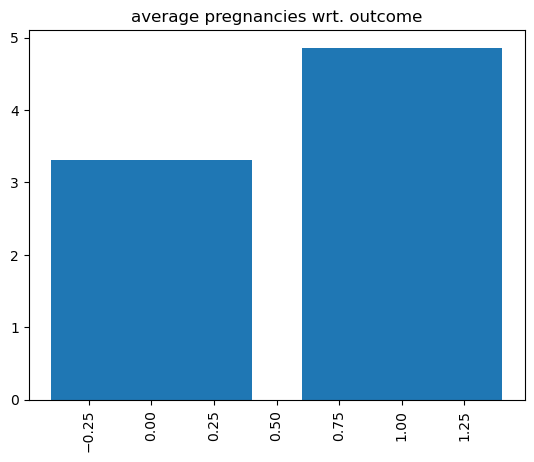

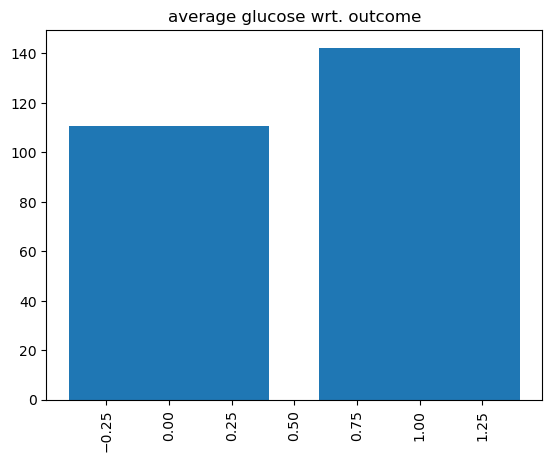

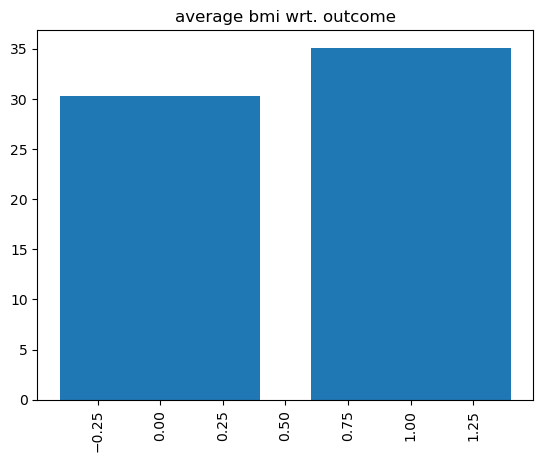

In [67]:
plt.bar(diabetes_df.groupby("outcome")
        ["pregnancies"].mean().index, diabetes_df.groupby("outcome")["pregnancies"].mean())
plt.title("average pregnancies wrt. outcome")
plt.xticks(rotation="vertical")
plt.show()

plt.bar(diabetes_df.groupby("outcome")
        ["glucose"].mean().index, diabetes_df.groupby("outcome")["glucose"].mean())
plt.title("average glucose wrt. outcome")
plt.xticks(rotation="vertical")
plt.show()

plt.bar(diabetes_df.groupby("outcome")
        ["bmi"].mean().index, diabetes_df.groupby("outcome")["bmi"].mean())
plt.title("average bmi wrt. outcome")
plt.xticks(rotation="vertical")
plt.show()



Based off our data, we can see that there is a high correlation with glucose, pregnancies and bmi are good indicators for whether a person has diabetes or not. Out of these three, glucose stands out the most as a key determinant due to having the highest correlation with diabetes. Therefore glucose would be the best indicator to use for a model.